## Imports

In [8]:
import pandas as pd
import re
import timeit
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.ensemble import IsolationForest
import plotly.express as px
import numpy as np
import warnings
import datetime
import xgboost as xgb
import math
import joblib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

#Imports TFG Original
from prettytable import PrettyTable
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score , mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LinearRegression



## Funció Alineament de Dades

In [9]:
def alignSeries(serie, lag):
    minutesRow = 30
    posToMove = int(lag / minutesRow)  
    outputSerie = serie['data'].to_numpy()
    size = len(outputSerie)
    outputSerie = np.pad(outputSerie, (posToMove,0), 'constant', constant_values=(0))
    outputSerie = outputSerie[:size]
    return outputSerie

## Carregar Dades

In [10]:
def prepareDFMod(df, col):
    output = df[[col]]
    output.rename(columns={col:'data'}, inplace=True)
    return output
    

In [11]:
# Carregar dades pluja
def loadDataPrecipitacions():
    precipitacions = pd.read_excel("finalsDF/DF_SMC.xlsx", index_col=0)
    return precipitacions

In [12]:
# Carregar dades Alt Ter
def loadDataTer(nom, Ter):
    
    altTer = prepareDFMod(Ter, nom)
    
    return altTer

In [13]:
#Carregar dades precipitacions Alt Ter:
def loadDataPrecipitacions(nom, precipitacions):
    
    #Carregar dades
    precipitacions = prepareDFMod(precipitacions, nom)
    
    #Moving Average
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    
    return precipitacions

In [14]:
altTer = pd.read_excel("Dataframes/df_imputedAltTerKNN.xlsx", index_col=0)
baixTer = pd.read_excel("Dataframes/df_imputedBaixTerKNN.xlsx", index_col=0)
precipitacions = pd.read_csv("finalsDF/DF_SMC.csv", index_col=0)

# Alineament del DataFrame amb Referencia (Alt Ter)

In [15]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [16]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [17]:
#Carregar Dades Comparatives

#Alinear Ripoll
ripoll = loadDataTer("L17147-72-00005", altTer)
ripoll = alignSeries(ripoll, 150)

#Alinear Sant Joan
santJoan = loadDataTer("L17167-72-00001", altTer)
santJoan = alignSeries(santJoan, 180)

#Alinear DG
DG = loadDataPrecipitacions("DG", precipitacions)
DG = alignSeries(DG, 270)

#Alinear CG 
CG = loadDataPrecipitacions("CG", precipitacions)
CG = alignSeries(CG, 300)

#Alinear CI
CI = loadDataPrecipitacions("CI", precipitacions)
CI = alignSeries(CI, 150)

#Alinear V4
V4 = loadDataPrecipitacions("V4", precipitacions)
V4 = alignSeries(V4, 180)

#Alinear CC
CC = loadDataPrecipitacions("CC", precipitacions)
CC = alignSeries(CC, 195)

#Alinear CY
CY = loadDataPrecipitacions("CY", precipitacions)
CY = alignSeries(CY, 240)

#Alinear VN
VN = loadDataPrecipitacions("VN", precipitacions)
VN = alignSeries(VN, 300)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 300)

#Alinear V3

V3 = loadDataPrecipitacions("V3", precipitacions)
V3 = alignSeries(V3, 210)

#Z4_ZC

In [18]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfAltX = pd.DataFrame(index=range(len(idx)))
dfAltX["L17147-72-00005"] = pd.Series(ripoll.tolist())
dfAltX["L17167-72-00001"] = pd.Series(santJoan.tolist())
dfAltX['DG'] = pd.Series(DG.tolist())
dfAltX['CG'] = pd.Series(CG.tolist())
dfAltX['CI'] = pd.Series(CI.tolist())
dfAltX['V4'] = pd.Series(V4.tolist())
dfAltX['CC'] = pd.Series(CC.tolist())
dfAltX['CY'] = pd.Series(CY.tolist())
dfAltX['VN'] = pd.Series(VN.tolist())
dfAltX['WS'] = pd.Series(WS.tolist())
dfAltX['V3'] = pd.Series(V3.tolist())



In [19]:
#Assignem les hores al index
dfAltX['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfAltX.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfAltX.drop(dfAltX.head(posToMove).index, inplace=True)
dfAltX.drop(dfAltX.tail(1).index, inplace=True)
dfAltX.fillna(0, inplace=True)


In [20]:
#Eliminem les mateixes columnes del 
masies = loadDataTer("L08116-72-00002", altTer)
masies.rename(columns={'data':'L08116-72-00002'}, inplace=True)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
masies.drop(masies.head(posToMove).index, inplace=True)
dfAltY = masies
dfAltX.fillna(0, inplace=True)
dfAltY.fillna(0, inplace=True)

In [21]:
#Guardem el matrix de X y el array de y en un csv

dfAltX.to_csv('dfAltX.csv')
dfAltY.to_csv('dfAltY.csv')

# Alineament del DataFrame amb Referencia (Baix Ter)

In [70]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [71]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [72]:
#Carregar Dades Comparatives

#Alinear L17199-72-00001

L171997200001 = loadDataTer("L17199-72-00001", baixTer)
L171997200001 = alignSeries(L171997200001, 300)

#Alinear F026458

F026458 = loadDataTer("F026458", baixTer)
F026458 = alignSeries(F026458, 300)

#Alinear F001242
F001242 = loadDataTer("F001242", baixTer)
F001242 = alignSeries(F001242, 300)

#Alinear L170797200005
L170797200005 = loadDataTer("L17079-72-00005", baixTer)
L170797200005 = alignSeries(L170797200005, 270)

#Alinear L17079-72-00004

L170797200004 = loadDataTer("L17079-72-00004", baixTer)
L170797200004 = alignSeries(L170797200004, 270)

#Alinear L17038-72-00002

L170387200002 = loadDataPrecipitacions("L17038-72-00002", baixTer)
L170387200002 = alignSeries(L170387200002, 270)

#Alinear KE
KE = loadDataPrecipitacions("KE", precipitacions)
KE = alignSeries(KE, 300)

#Alinear UO
UO = loadDataPrecipitacions("UO", precipitacions)
UO = alignSeries(UO, 480)

#Alinear UN
UN = loadDataPrecipitacions("UN", precipitacions)
UN = alignSeries(UN, 405)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 270)

#Alinear DJ

DJ = loadDataPrecipitacions("DJ", precipitacions)
DJ = alignSeries(DJ, 360)



In [73]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfBaixX = pd.DataFrame(index=range(len(idx)))
dfBaixX["L17199-72-00001"] = pd.Series(L171997200001.tolist())
dfBaixX["F026458"] = pd.Series(F026458.tolist())
dfBaixX['F001242'] = pd.Series(F001242.tolist())
dfBaixX['L17079-72-00005'] = pd.Series(L170797200005.tolist())
dfBaixX['L17079-72-00004'] = pd.Series(L170797200004.tolist())
dfBaixX['L17038-72-00002'] = pd.Series(L170387200002.tolist())
dfBaixX['KE'] = pd.Series(KE.tolist())
dfBaixX['UO'] = pd.Series(UO.tolist())
dfBaixX['UN'] = pd.Series(UN.tolist())
dfBaixX['WS'] = pd.Series(WS.tolist())
dfBaixX['DJ'] = pd.Series(DJ.tolist())




In [74]:
#Assignem les hores al index
dfBaixX['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfBaixX.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfBaixX.drop(dfBaixX.head(posToMove).index, inplace=True)
dfBaixX.drop(dfBaixX.tail(1).index, inplace=True)
dfBaixX.fillna(0, inplace=True)

In [75]:
#Eliminem les mateixes columnes del 
colomers = loadDataTer("L17055-72-00002", baixTer)
colomers.rename(columns={'data':'L17055-72-00002'}, inplace=True)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
colomers.drop(colomers.head(posToMove).index, inplace=True)
dfBaixY = colomers
dfBaixX.fillna(0, inplace=True)
dfBaixY.fillna(0, inplace=True)

In [76]:
#Guardem el matrix de X y el array de y en un csv

dfBaixX.to_csv('dfBaixX.csv')
dfBaixY.to_csv('dfBaixY.csv')

# Models Alt Ter

# Random Forest (Alt Ter)

In [29]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [30]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

In [31]:
df_results_altTer = pd.DataFrame(columns = ["Method", "Best_Params", "Features","Feature_Importance", "Score","RMSE_Score","Prediccio_Hores"])

Iteració:  1
CPU times: total: 1.7 s
Wall time: 55.7 s


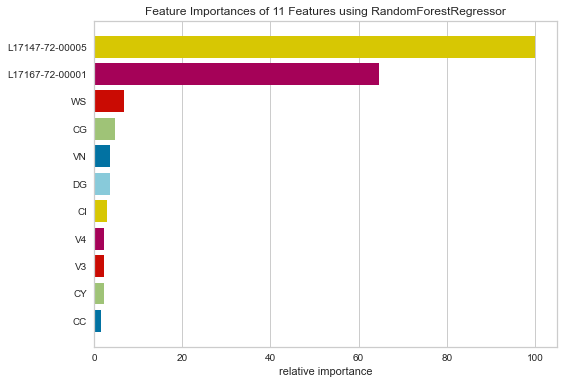

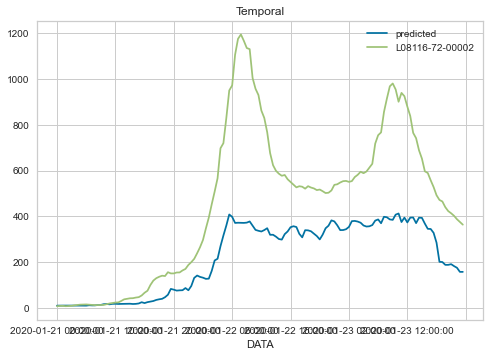

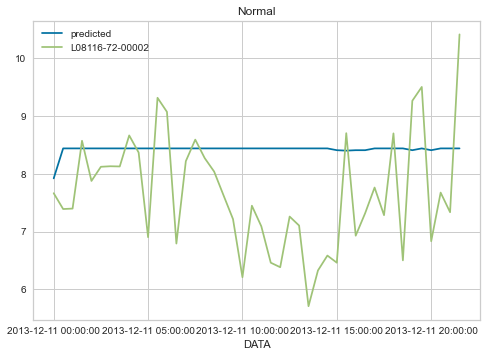

Iteració:  2
CPU times: total: 7 s
Wall time: 2min 9s


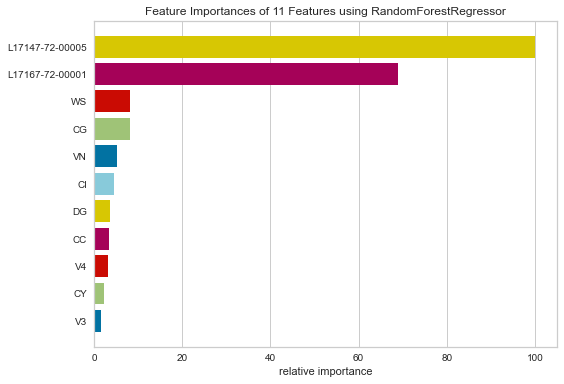

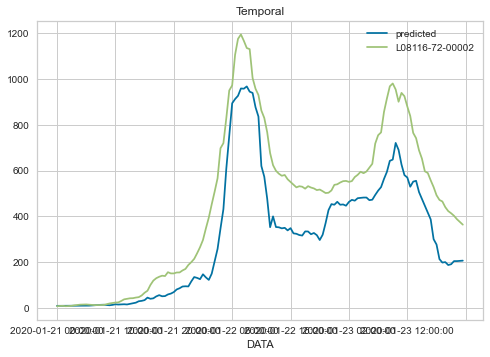

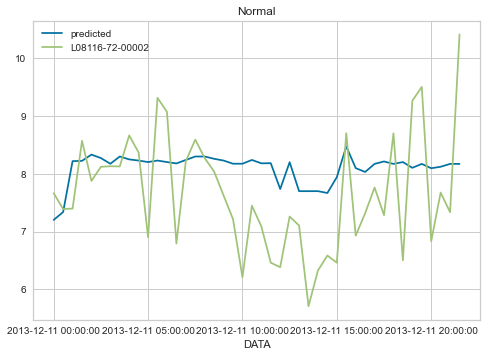

Iteració:  3
CPU times: total: 41.5 s
Wall time: 4min 19s


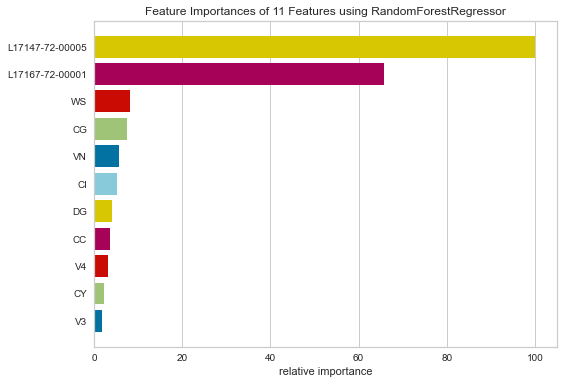

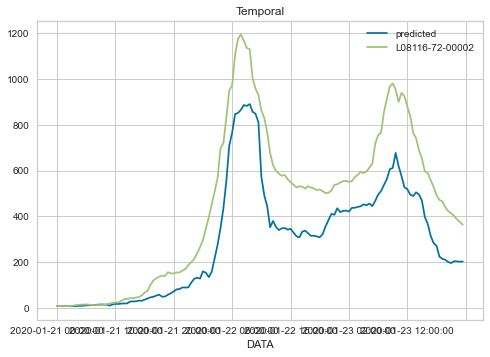

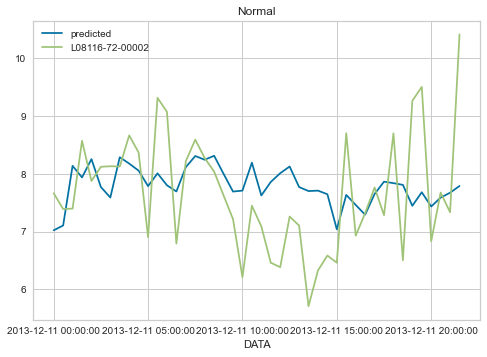

Time:  0:07:35.265840


In [32]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    new_row = {'Method':'Random Forest','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/RandomForest_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtest = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Alty["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [33]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.5138630095432495, 0.3323375218681935, 0.018...",0.718582,13.855238,1 day
1,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.47752435171675944, 0.3293310776119073, 0.01...",0.769947,7.124326,1 day
2,Random Forest,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.4822828803737737, 0.31727848837305705, 0.01...",0.840339,16.537039,1 day


# XGBoost (Alt Ter)

In [34]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [35]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

Iteració:  1
[19:43:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 6.22 s
Wall time: 1min 55s


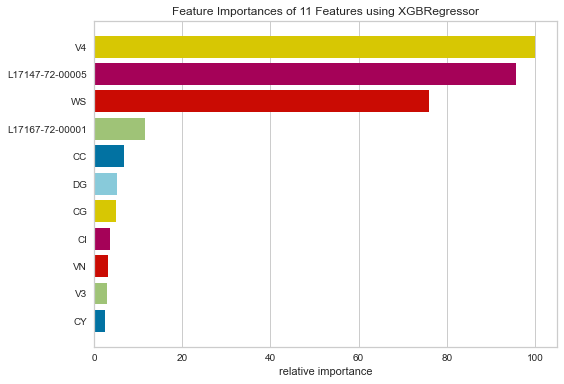

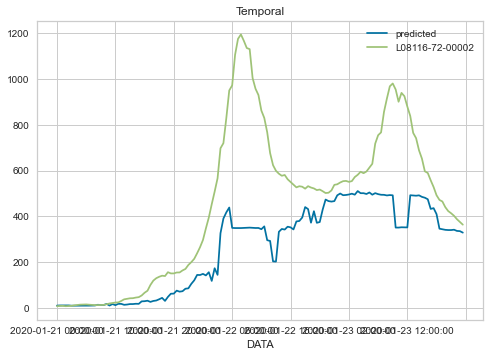

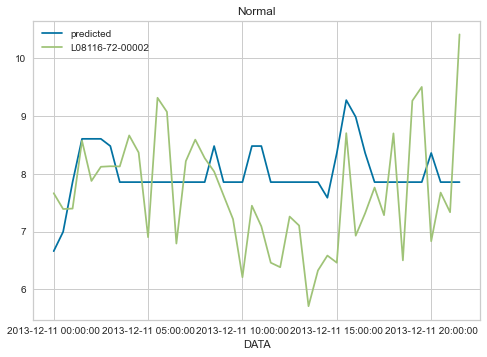

Iteració:  2
[19:47:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 11 s
Wall time: 3min 52s


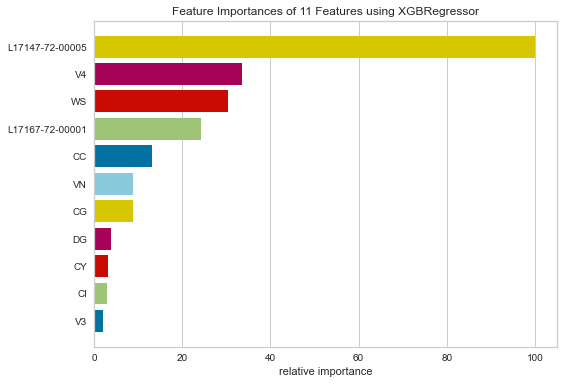

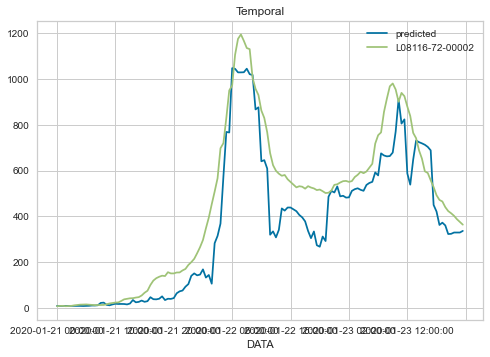

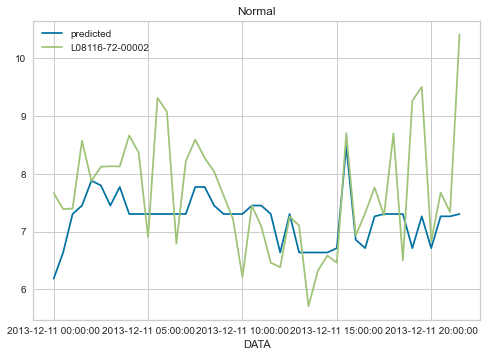

Iteració:  3
[19:53:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 14.2 s
Wall time: 5min 43s


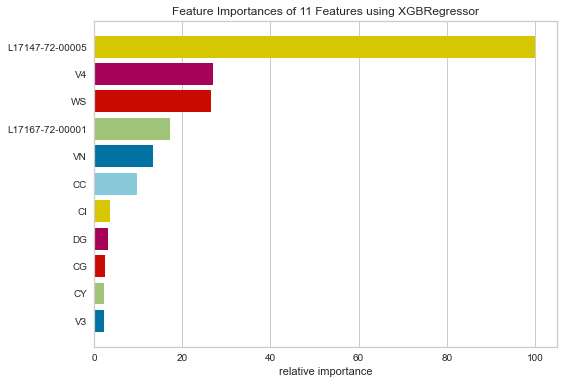

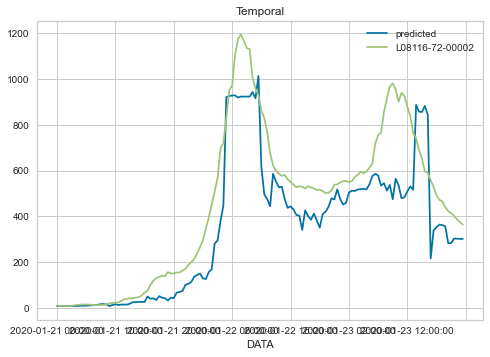

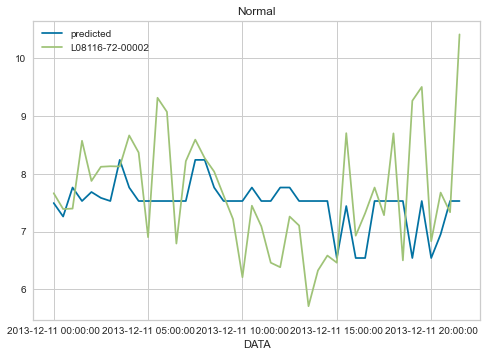

Time:  0:11:33.714107


In [36]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    new_row = {'Method':'XGBoost','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/XGBoost_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtest = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Alty["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [37]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.5138630095432495, 0.3323375218681935, 0.018...",0.718582,13.855238,1 day
1,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.47752435171675944, 0.3293310776119073, 0.01...",0.769947,7.124326,1 day
2,Random Forest,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.4822828803737737, 0.31727848837305705, 0.01...",0.840339,16.537039,1 day
3,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.30657864, 0.036931094, 0.01652835, 0.015944...",0.664765,15.122113,1 day
4,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.43312925, 0.10543266, 0.01687218, 0.0378511...",0.659946,8.661701,1 day
5,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.48192567, 0.08306265, 0.015356588, 0.012260...",0.857018,15.649445,1 day


# ExtraTrees (Alt Ter)

In [38]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [39]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

Iteració:  1
CPU times: total: 3.77 s
Wall time: 33.6 s


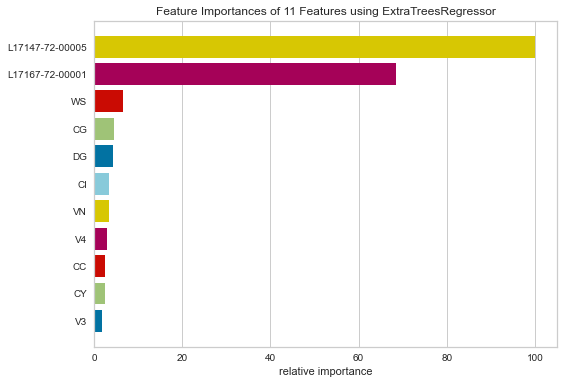

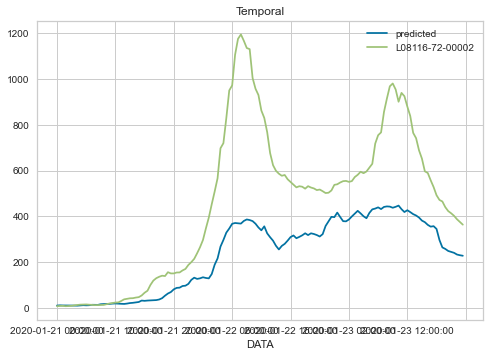

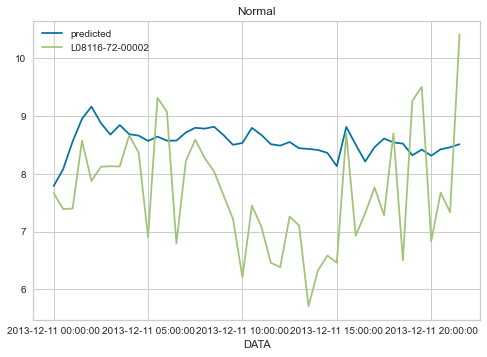

Iteració:  2
CPU times: total: 4.25 s
Wall time: 1min 11s


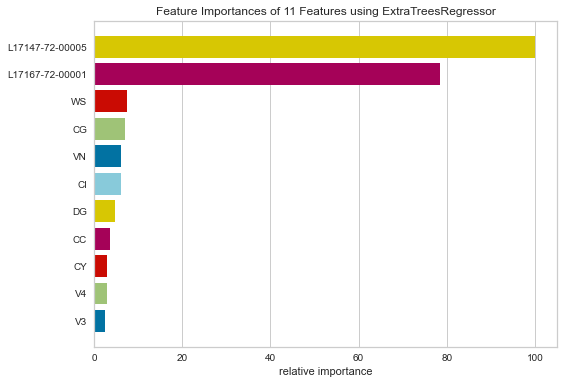

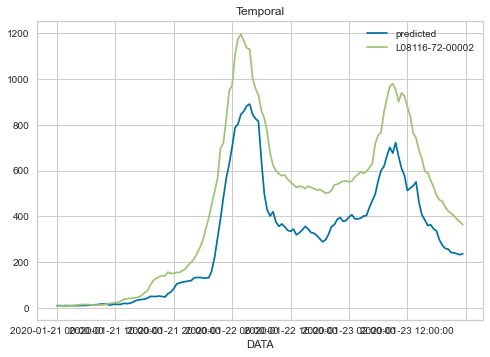

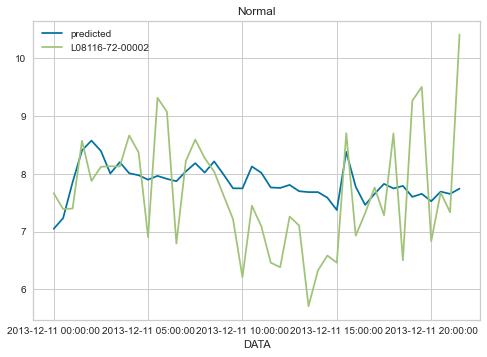

Iteració:  3
CPU times: total: 5.88 s
Wall time: 3min 18s


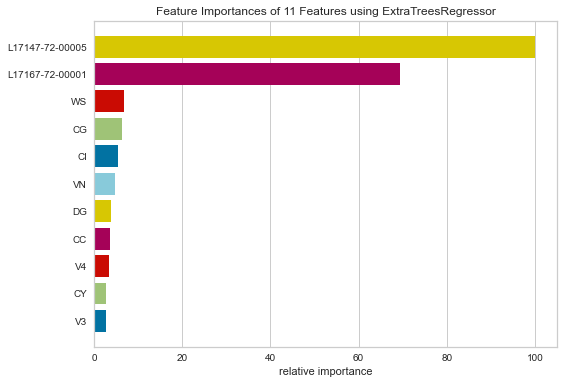

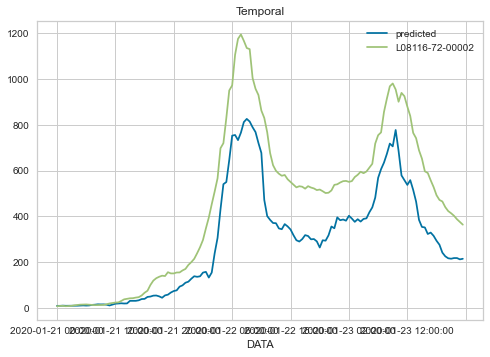

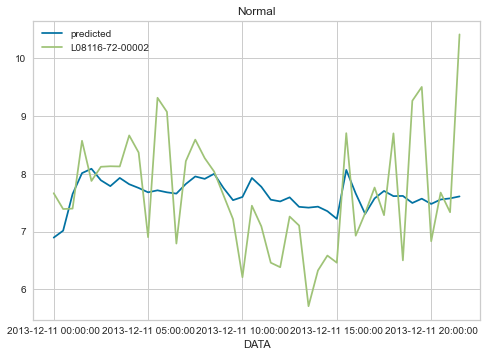

Time:  0:05:11.178097


In [40]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    new_row = {'Method':'ExtraTrees','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/ExtraTrees_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtest = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Alty["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [41]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.5138630095432495, 0.3323375218681935, 0.018...",0.718582,13.855238,1 day
1,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.47752435171675944, 0.3293310776119073, 0.01...",0.769947,7.124326,1 day
2,Random Forest,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.4822828803737737, 0.31727848837305705, 0.01...",0.840339,16.537039,1 day
3,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.30657864, 0.036931094, 0.01652835, 0.015944...",0.664765,15.122113,1 day
4,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.43312925, 0.10543266, 0.01687218, 0.0378511...",0.659946,8.661701,1 day
5,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.48192567, 0.08306265, 0.015356588, 0.012260...",0.857018,15.649445,1 day
6,ExtraTrees,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.49777603041248686, 0.3412849567624941, 0.02...",0.727358,13.637489,1 day
7,ExtraTrees,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.4509883379800842, 0.35350843644339763, 0.02...",0.781024,6.950689,1 day
8,ExtraTrees,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.47763683124553824, 0.33179250336187566, 0.0...",0.835783,16.771337,1 day


# Linear Regression (Alt Ter)

In [42]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [43]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

Iteració:  1
CPU times: total: 266 ms
Wall time: 362 ms


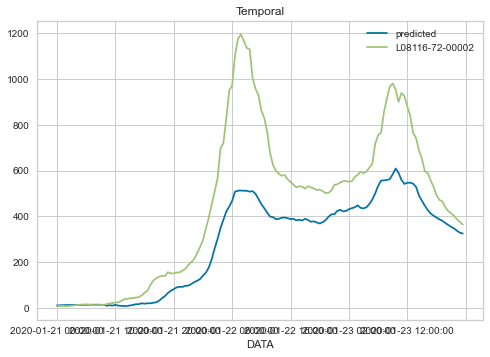

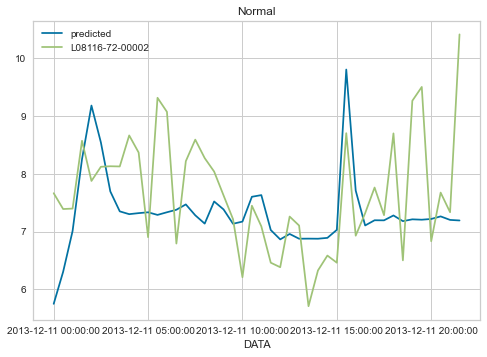

Iteració:  2
CPU times: total: 31.2 ms
Wall time: 15 ms


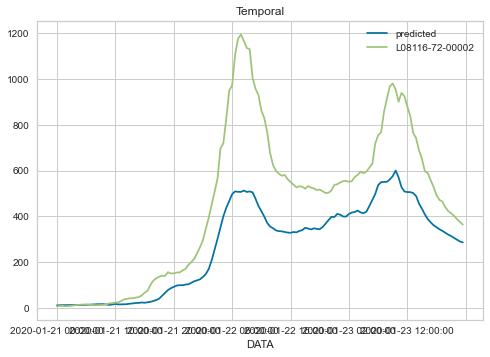

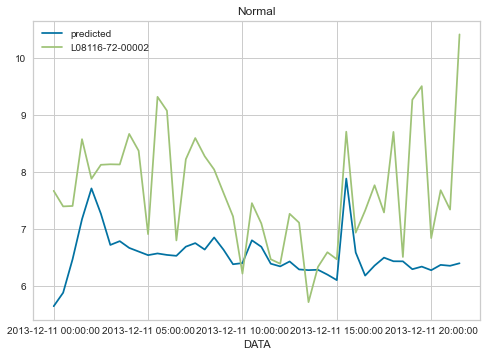

Iteració:  3
CPU times: total: 15.6 ms
Wall time: 24 ms


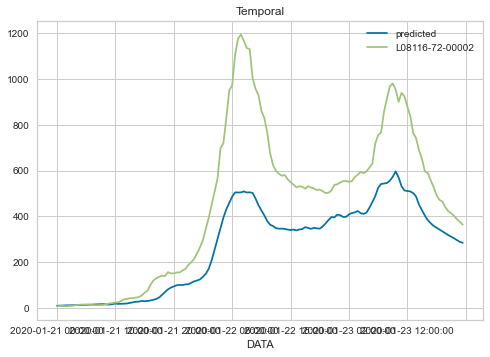

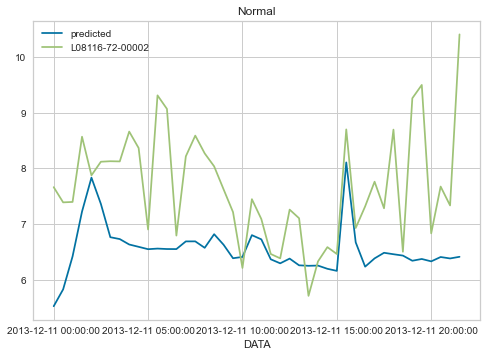

Time:  0:00:01.181309


In [44]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_AltX_train, Df_Alty_train)
        
    score = modelfited.score(Df_AltX_test, Df_Alty_test)
    
    predicty = modelfited.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    

    hores = "1 day"
    
    new_row = {'Method':'LinearRegression','Best_Params':"no avaliable", 'Features':Df_AltX.columns, 'Feature_Importance':"no avaliable", 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(modelfited, 'resultsDf/pickle/partAlta/LinearRegression_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)
    
    plotYtest = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Alty["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = modelfited.predict(plotXtestp.values)
    plotXtest2r = modelfited.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [45]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.5138630095432495, 0.3323375218681935, 0.018...",0.718582,13.855238,1 day
1,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.47752435171675944, 0.3293310776119073, 0.01...",0.769947,7.124326,1 day
2,Random Forest,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.4822828803737737, 0.31727848837305705, 0.01...",0.840339,16.537039,1 day
3,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.30657864, 0.036931094, 0.01652835, 0.015944...",0.664765,15.122113,1 day
4,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.43312925, 0.10543266, 0.01687218, 0.0378511...",0.659946,8.661701,1 day
5,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.48192567, 0.08306265, 0.015356588, 0.012260...",0.857018,15.649445,1 day
6,ExtraTrees,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.49777603041248686, 0.3412849567624941, 0.02...",0.727358,13.637489,1 day
7,ExtraTrees,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.4509883379800842, 0.35350843644339763, 0.02...",0.781024,6.950689,1 day
8,ExtraTrees,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.47763683124553824, 0.33179250336187566, 0.0...",0.835783,16.771337,1 day
9,LinearRegression,no avaliable,"Index(['L17147-72-00005', 'L17167-72-00001', '...",no avaliable,0.73637,13.410186,1 day


# Models Baix Ter

# Random Forest (Baix Ter)

In [46]:
#Carregar del csv
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [47]:
Df_BaixX.set_index('datetime', drop=True, inplace=True)
Df_Baixy.set_index('DATA', drop=True, inplace=True)

In [48]:
df_results_baixTer = pd.DataFrame(columns = ["Method", "Best_Params", "Features","Feature_Importance", "Score","RMSE_Score","Prediccio_Hores"])

Iteració:  1
CPU times: total: 4.03 s
Wall time: 56.8 s


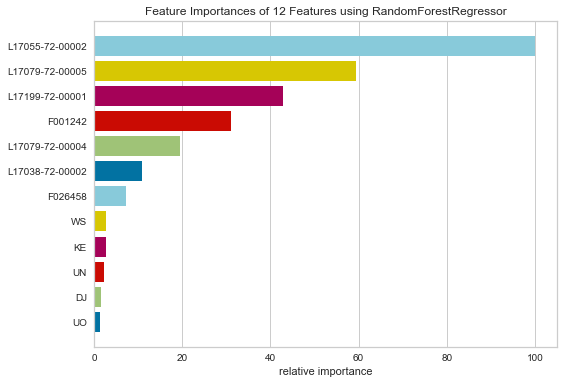

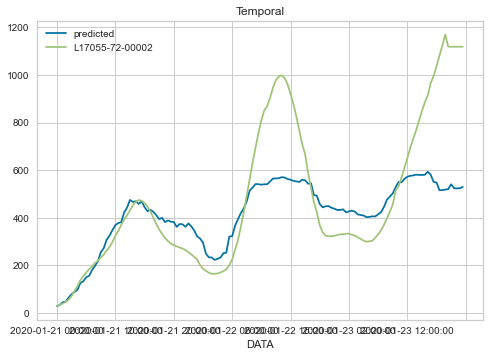

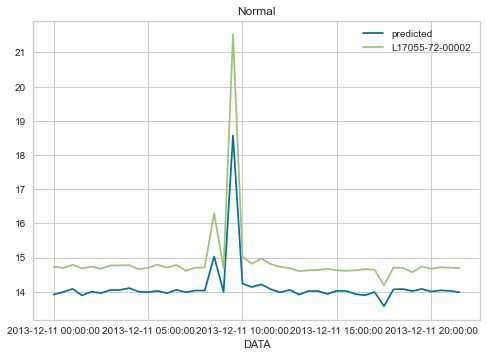

Iteració:  2
CPU times: total: 9.5 s
Wall time: 2min 24s


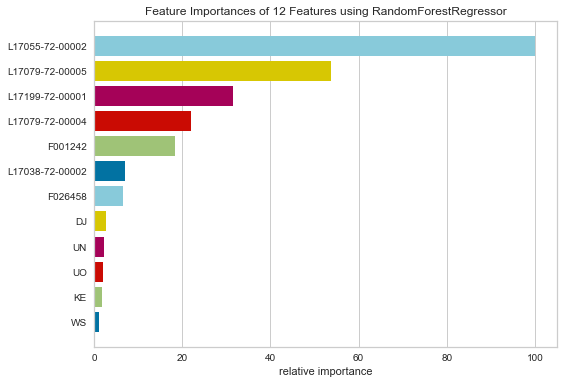

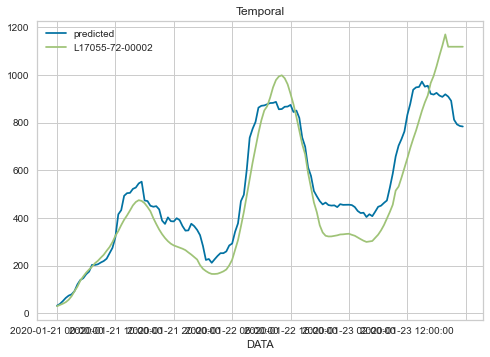

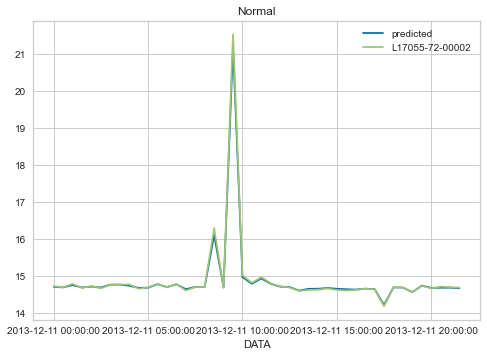

Iteració:  3
CPU times: total: 14.4 s
Wall time: 4min 12s


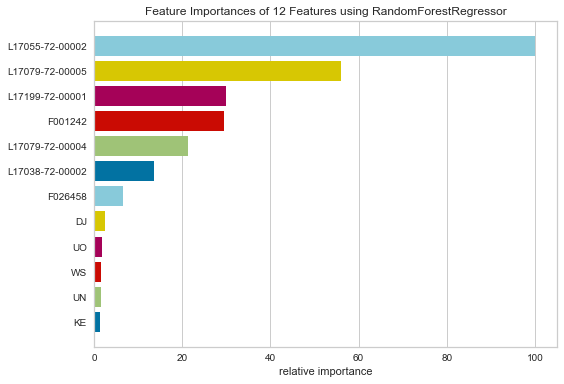

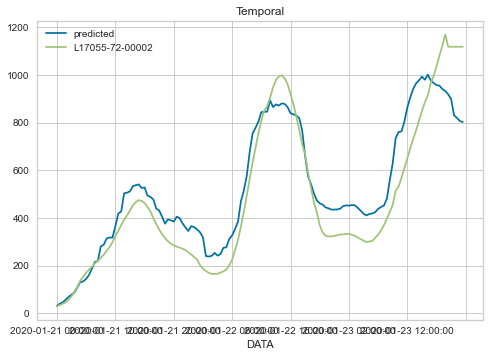

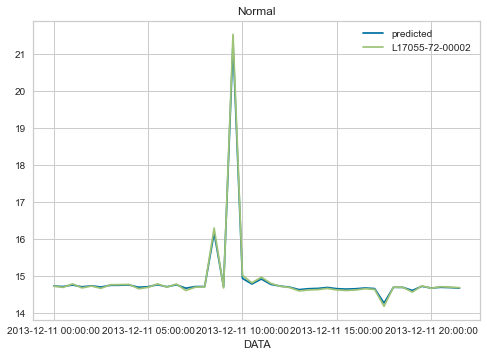

Time:  0:07:41.364574


In [49]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    new_row = {'Method':'Random Forest','Best_Params':bestParams, 'Features':Df_BaixX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/RandomForest_'+str(df_results_baixTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtest = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Baixy["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_BaixX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [50]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.15238170157996114, 0.02568608299337111, 0.1...",0.893287,11.313629,1 day
1,Random Forest,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.12641560692076895, 0.02671549299047169, 0.0...",0.982386,0.906972,1 day
2,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.11237714700593748, 0.024673501712312716, 0....",0.875656,20.232317,1 day


# XGBoost (Baix Ter)

In [77]:
#Carregar del csv
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [78]:
Df_BaixX.set_index('datetime', drop=True, inplace=True)
Df_Baixy.set_index('DATA', drop=True, inplace=True)

Iteració:  1
[20:35:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 13.9 s
Wall time: 2min 9s


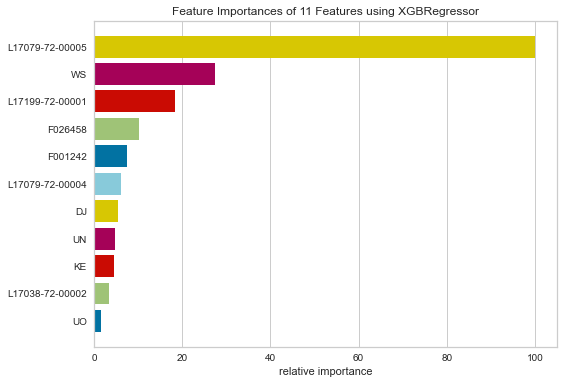

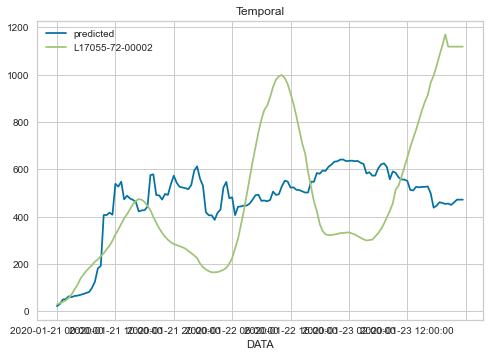

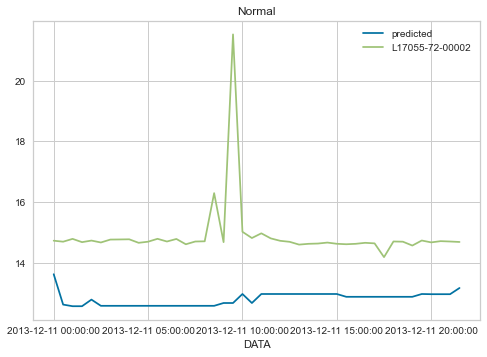

Iteració:  2
[20:40:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 14.8 s
Wall time: 4min 48s


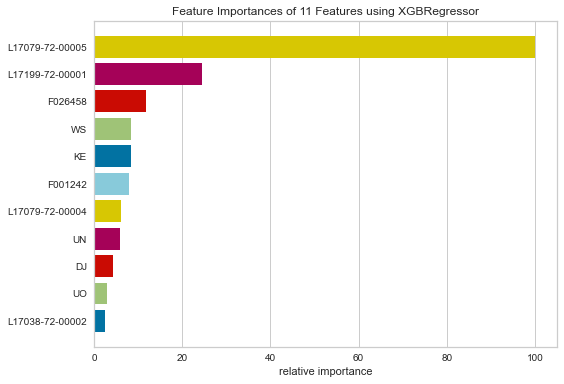

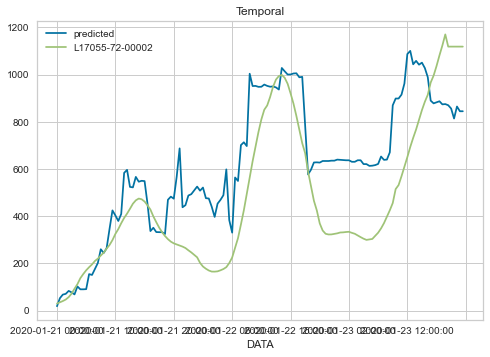

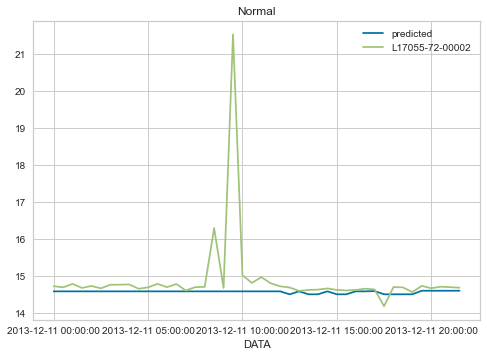

Iteració:  3
[20:47:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 20.6 s
Wall time: 7min 17s


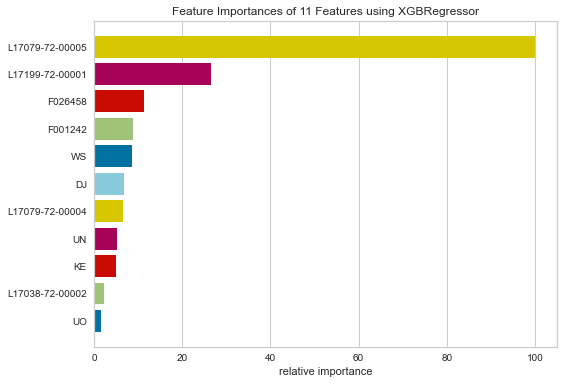

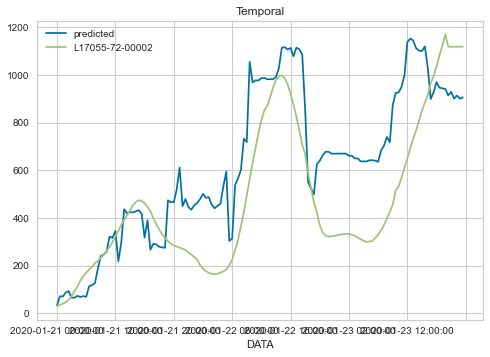

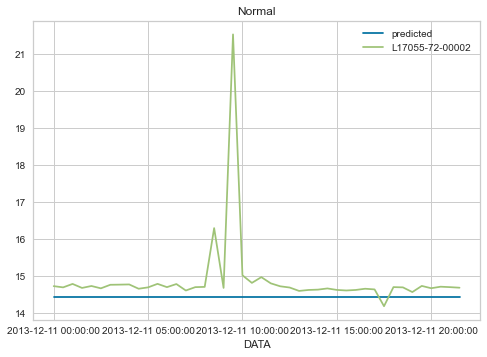

Time:  0:14:17.255433


In [79]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    new_row = {'Method':'XGBoost','Best_Params':bestParams, 'Features':Df_BaixX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/XGBoost_'+str(df_results_baixTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtest = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Baixy["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_BaixX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [80]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.15238170157996114, 0.02568608299337111, 0.1...",0.893287,11.313629,1 day
1,Random Forest,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.12641560692076895, 0.02671549299047169, 0.0...",0.982386,0.906972,1 day
2,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.11237714700593748, 0.024673501712312716, 0....",0.875656,20.232317,1 day
3,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[2.8497623e-05, 2.962082e-05, 5.8029633e-05, 4...",0.970654,5.93296,1 day
4,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[2.7942293e-05, 0.000113556394, 1.3800968e-05,...",0.999985,0.026461,1 day
5,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[2.6925027e-05, 0.0001876164, 2.2630164e-05, 1...",0.997926,2.613249,1 day
6,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.09810789991503367, 0.019128751582981378, 0....",0.898045,11.05854,1 day
7,ExtraTrees,"{'max_depth': None, 'max_features': 'log2', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.12615478772069852, 0.02015301376088523, 0.1...",0.978038,1.01276,1 day
8,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1316209457050064, 0.018425156407818815, 0.1...",0.911898,17.030477,1 day
9,LinearRegression,no avaliable,"Index(['L17199-72-00001', 'F026458', 'F001242'...",no avaliable,1.0,0.0,1 day


# ExtraTrees (Baix Ter)

In [81]:
#Carregar del csv
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [82]:
Df_BaixX.set_index('datetime', drop=True, inplace=True)
Df_Baixy.set_index('DATA', drop=True, inplace=True)

Iteració:  1
CPU times: total: 1.45 s
Wall time: 34.6 s


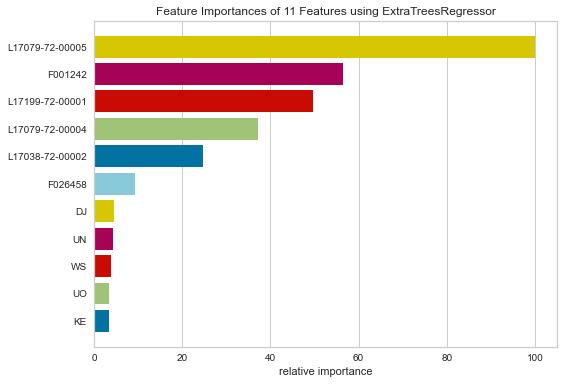

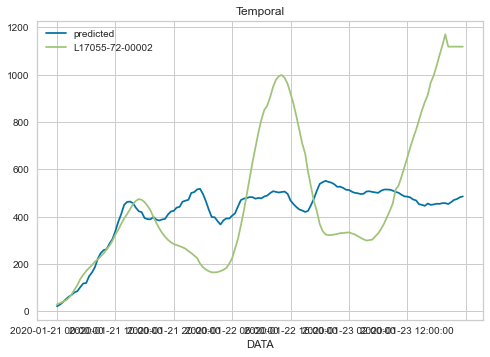

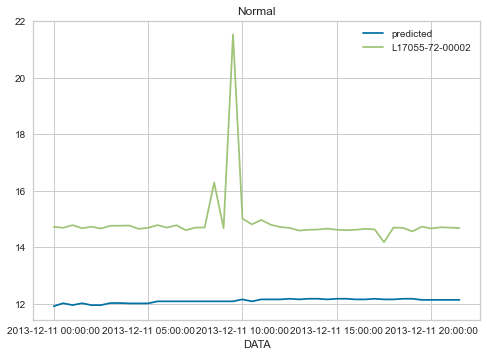

Iteració:  2
CPU times: total: 1.69 s
Wall time: 1min 10s


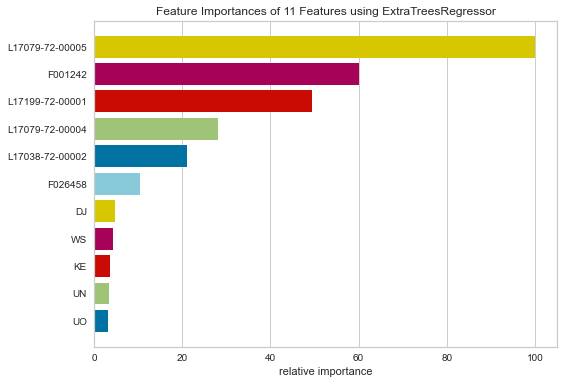

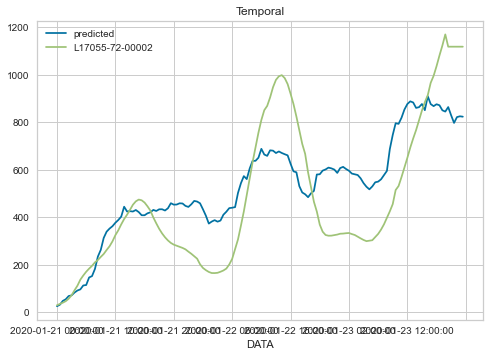

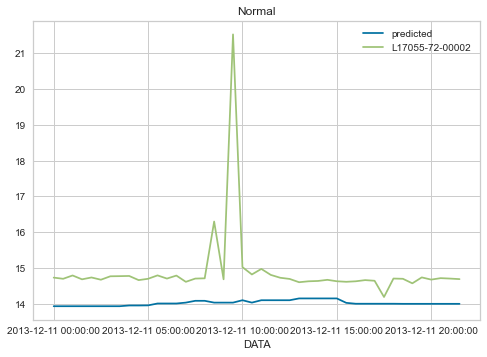

Iteració:  3
CPU times: total: 17.5 s
Wall time: 2min 39s


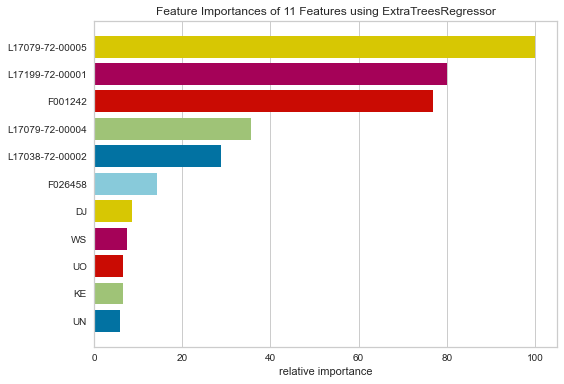

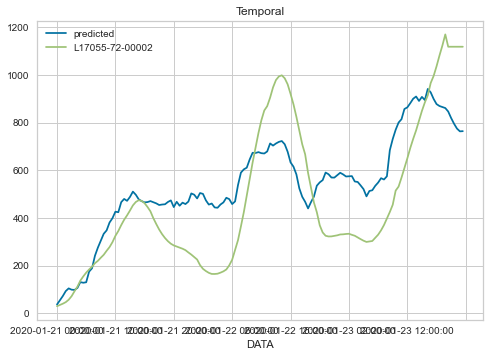

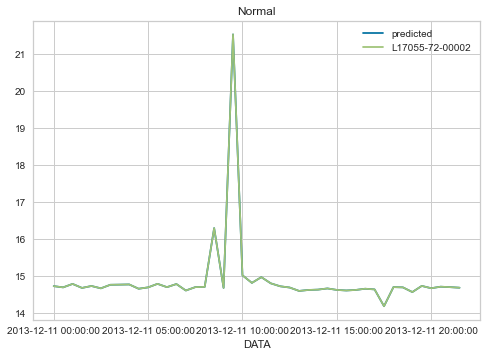

Time:  0:04:44.448143


In [83]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    new_row = {'Method':'ExtraTrees','Best_Params':bestParams, 'Features':Df_BaixX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/ExtraTrees_'+str(df_results_baixTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtest = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Baixy["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_BaixX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [84]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.15238170157996114, 0.02568608299337111, 0.1...",0.893287,11.313629,1 day
1,Random Forest,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.12641560692076895, 0.02671549299047169, 0.0...",0.982386,0.906972,1 day
2,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.11237714700593748, 0.024673501712312716, 0....",0.875656,20.232317,1 day
3,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[2.8497623e-05, 2.962082e-05, 5.8029633e-05, 4...",0.970654,5.93296,1 day
4,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[2.7942293e-05, 0.000113556394, 1.3800968e-05,...",0.999985,0.026461,1 day
5,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[2.6925027e-05, 0.0001876164, 2.2630164e-05, 1...",0.997926,2.613249,1 day
6,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.09810789991503367, 0.019128751582981378, 0....",0.898045,11.05854,1 day
7,ExtraTrees,"{'max_depth': None, 'max_features': 'log2', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.12615478772069852, 0.02015301376088523, 0.1...",0.978038,1.01276,1 day
8,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1316209457050064, 0.018425156407818815, 0.1...",0.911898,17.030477,1 day
9,LinearRegression,no avaliable,"Index(['L17199-72-00001', 'F026458', 'F001242'...",no avaliable,1.0,0.0,1 day


# Linear Regression (Baix Ter)

In [85]:
#Carregar del csv
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [86]:
Df_BaixX.set_index('datetime', drop=True, inplace=True)
Df_Baixy.set_index('DATA', drop=True, inplace=True)

Iteració:  1
CPU times: total: 156 ms
Wall time: 63.1 ms


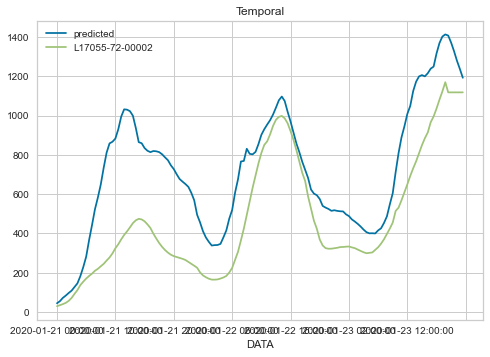

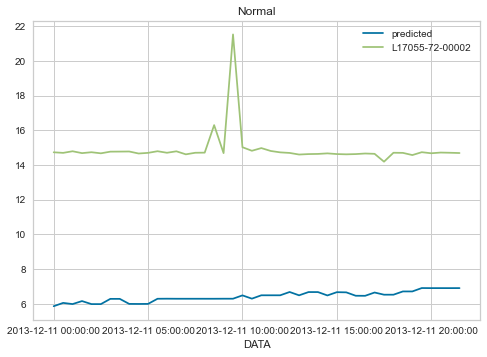

Iteració:  2
CPU times: total: 15.6 ms
Wall time: 18.5 ms


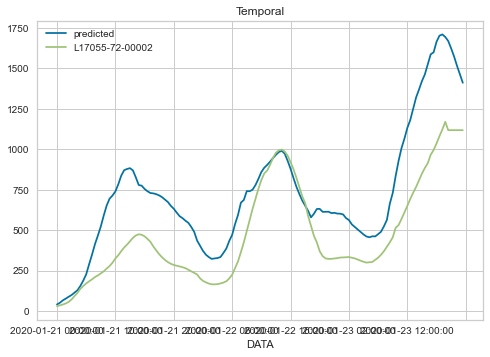

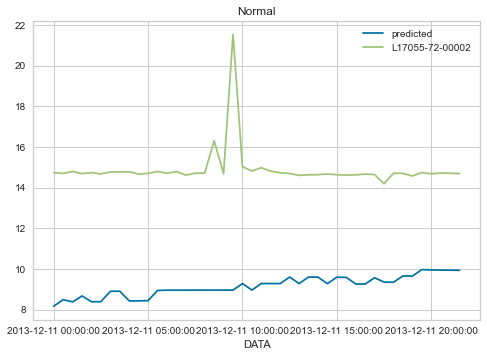

Iteració:  3
CPU times: total: 109 ms
Wall time: 29 ms


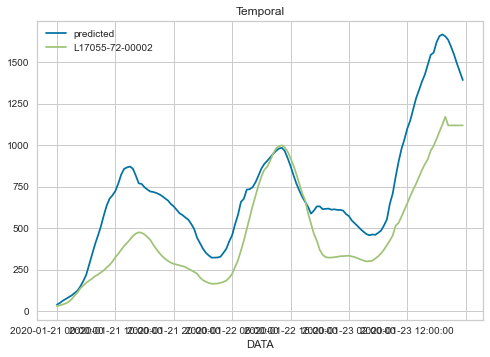

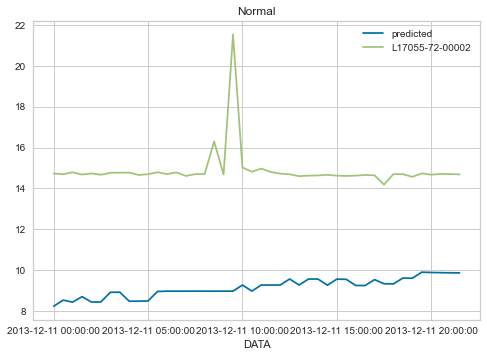

Time:  0:00:01.302125


In [87]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_BaixX_train, Df_Baixy_train)
        
    score = modelfited.score(Df_BaixX_test, Df_Baixy_test)
    
    predicty = modelfited.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    

    hores = "1 day"
    
    new_row = {'Method':'LinearRegression','Best_Params':"no avaliable", 'Features':Df_BaixX.columns, 'Feature_Importance':"no avaliable", 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)
    
    joblib.dump(modelfited, 'resultsDf/pickle/partAlta/LinearRegression_'+str(df_results_baixTer.index[-1])+'.pkl', compress = 1)
    
    plotYtest = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Baixy["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_BaixX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = modelfited.predict(plotXtestp.values)
    plotXtest2r = modelfited.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [88]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.15238170157996114, 0.02568608299337111, 0.1...",0.893287,11.313629,1 day
1,Random Forest,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.12641560692076895, 0.02671549299047169, 0.0...",0.982386,0.906972,1 day
2,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.11237714700593748, 0.024673501712312716, 0....",0.875656,20.232317,1 day
3,XGBoost,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[2.8497623e-05, 2.962082e-05, 5.8029633e-05, 4...",0.970654,5.93296,1 day
4,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[2.7942293e-05, 0.000113556394, 1.3800968e-05,...",0.999985,0.026461,1 day
5,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[2.6925027e-05, 0.0001876164, 2.2630164e-05, 1...",0.997926,2.613249,1 day
6,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.09810789991503367, 0.019128751582981378, 0....",0.898045,11.05854,1 day
7,ExtraTrees,"{'max_depth': None, 'max_features': 'log2', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.12615478772069852, 0.02015301376088523, 0.1...",0.978038,1.01276,1 day
8,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1316209457050064, 0.018425156407818815, 0.1...",0.911898,17.030477,1 day
9,LinearRegression,no avaliable,"Index(['L17199-72-00001', 'F026458', 'F001242'...",no avaliable,1.0,0.0,1 day
